# 0. 필요한 모듈 설치



In [ ]:
!pip install transformers torch
!pip install matplotlib




# 1. 코사인 유사도 계산 및 경향성 확인



In [2]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('train.csv')
df.head()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = "deliciouscat/kf-deberta-base-cross-sts"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.09M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.19M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/971 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/744M [00:00<?, ?B/s]

In [ ]:
def get_embedding(text, model, tokenizer, device):
        inputs = tokenizer(text, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze()

def cos_sim(sentence1, sentence2, model, tokenizer, device):
    sentence1_emb = get_embedding(sentence1, model, tokenizer, device)
    sentence2_emb = get_embedding(sentence2, model, tokenizer, device)
    return torch.dot(sentence1_emb, sentence2_emb) / (torch.norm(sentence1_emb) * torch.norm(sentence2_emb))

In [ ]:
cosine_similarities = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    cos_sim_score = cos_sim(row['sentence_1'], row['sentence_2'], model, tokenizer, device)
    cosine_similarities.append(cos_sim_score.item())

df['cos_sim'] = cosine_similarities

df.head()

100%|██████████| 9324/9324 [2:12:45<00:00,  1.17it/s]


,id,source,sentence_1,sentence_2,label,binary-label,cos_sim
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0,0.975745
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0,0.961706
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0,0.990128
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0,0.972689
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0,0.954042


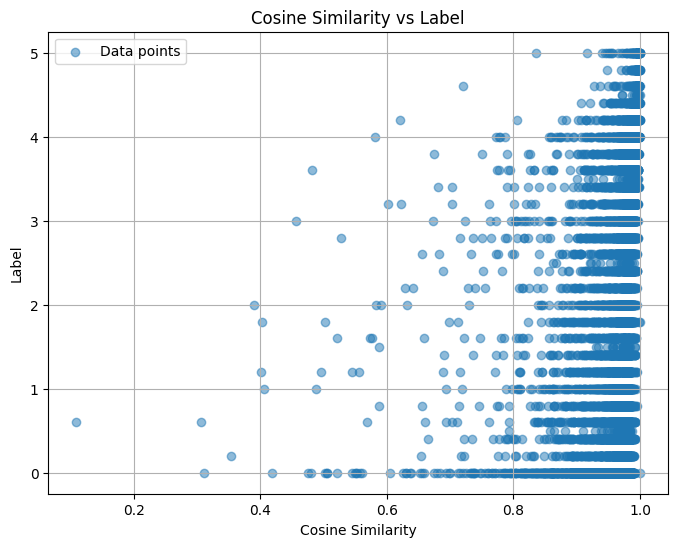

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df['cos_sim'], df['label'], alpha=0.5, label='Data points')
plt.title('Cosine Similarity vs Label')
plt.xlabel('Cosine Similarity')
plt.ylabel('Label')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
group_1 = df[df['cos_sim'] <= 0.961]
group_2 = df[(df['cos_sim'] > 0.961) & (df['cos_sim'] <= 0.980)]
group_3 = df[df['cos_sim'] > 0.981]

print(f"Group 1 (0.961 이하): {len(group_1)} rows")
print(f"Group 2 (0.962 ~ 0.980): {len(group_2)} rows")
print(f"Group 3 (0.981 이상): {len(group_3)} rows")

group_1.to_csv('group_1.csv', index=False)
group_2.to_csv('group_2.csv', index=False)
group_3.to_csv('group_3.csv', index=False)

Group 1 (0.961 이하): 3179 rows
Group 2 (0.962 ~ 0.980): 2935 rows
Group 3 (0.981 이상): 3008 rows


In [ ]:
df = pd.read_csv('dev.csv')
df.head()

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-dev-000,nsmc-sampled,액션은개뿔 총몇번쏘고 끝입니다,액션은 흉내만 내고 그마저도 후반부에는 슬로우모션 처리,2.0,0.0
1,boostcamp-sts-v1-dev-001,slack-rtt,감격스러워 입막으심?,너무 감동해서 입 다물어?,3.4,1.0
2,boostcamp-sts-v1-dev-002,nsmc-rtt,이번 년도에 본 영화 중 가장 최악의 영화......,올해 본 영화 중 최악...,4.0,1.0
3,boostcamp-sts-v1-dev-003,slack-rtt,특히 평소 뮤직채널에 많은 영감을 불어넣어주시는!,"특히, 당신은 항상 많은 음악 채널에 영감을 줍니다!",3.4,1.0
4,boostcamp-sts-v1-dev-004,slack-sampled,다음 밥스테이지가 기대됩니다~ ㅎ,다음 후기도 기대됩니다~~,1.4,0.0


In [ ]:
cosine_similarities = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    cos_sim_score = cos_sim(row['sentence_1'], row['sentence_2'], model, tokenizer, device)
    cosine_similarities.append(cos_sim_score.item())

df['cos_sim'] = cosine_similarities


df.to_csv('dev_cossim.csv', index=False)
df.head()

100%|██████████| 550/550 [07:21<00:00,  1.25it/s]


,id,source,sentence_1,sentence_2,label,binary-label,cos_sim
0,boostcamp-sts-v1-dev-000,nsmc-sampled,액션은개뿔 총몇번쏘고 끝입니다,액션은 흉내만 내고 그마저도 후반부에는 슬로우모션 처리,2.0,0.0,0.949749
1,boostcamp-sts-v1-dev-001,slack-rtt,감격스러워 입막으심?,너무 감동해서 입 다물어?,3.4,1.0,0.985532
2,boostcamp-sts-v1-dev-002,nsmc-rtt,이번 년도에 본 영화 중 가장 최악의 영화......,올해 본 영화 중 최악...,4.0,1.0,0.812275
3,boostcamp-sts-v1-dev-003,slack-rtt,특히 평소 뮤직채널에 많은 영감을 불어넣어주시는!,"특히, 당신은 항상 많은 음악 채널에 영감을 줍니다!",3.4,1.0,0.977108
4,boostcamp-sts-v1-dev-004,slack-sampled,다음 밥스테이지가 기대됩니다~ ㅎ,다음 후기도 기대됩니다~~,1.4,0.0,0.966731


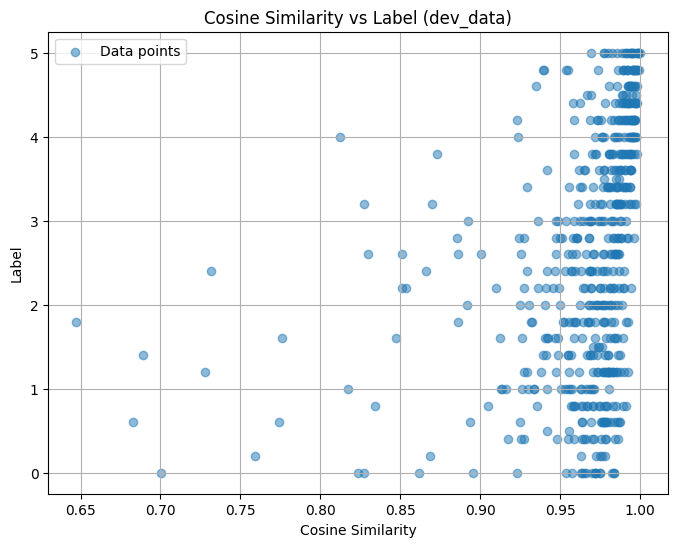

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df['cos_sim'], df['label'], alpha=0.5, label='Data points')
plt.title('Cosine Similarity vs Label (dev_data)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Label')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
df = pd.read_csv('dev_cossim.csv')

dev_1 = df[df['cos_sim'] <= 0.981]
dev_3 = df[df['cos_sim'] > 0.981]

print(f"Group 1 (0.985 이하): {len(dev_1)} rows")
print(f"Group 3 (0.985 이상): {len(dev_3)} rows")

dev_1.to_csv('dev_1.csv', index=False)
dev_3.to_csv('dev_3.csv', index=False)

Group 1 (0.985 이하): 318 rows
Group 3 (0.985 이상): 232 rows


Group 3 (0.982 이상): 3008 rows
Group 1 (0.981 이하): 6316 rows


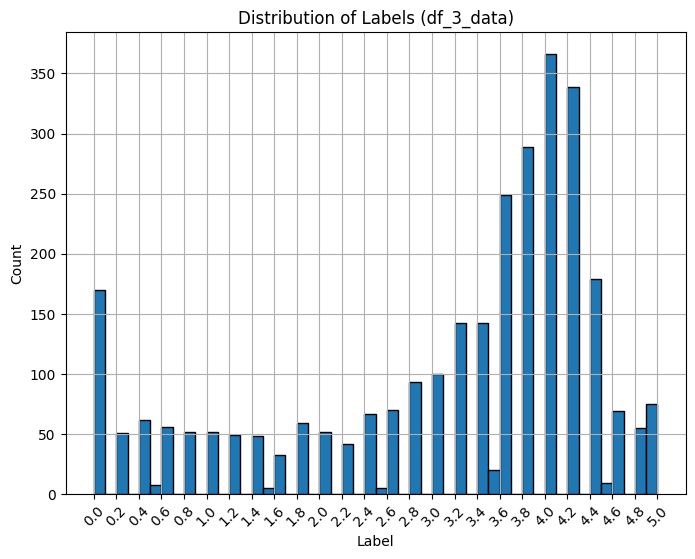

In [7]:
df = pd.read_csv('cos_sim.csv')

group_3 = df[df['cos_sim'] > 0.981]
print(f"Group 3 (0.982 이상): {len(group_3)} rows")
group_1 = df[df['cos_sim'] <= 0.981]

group_1.to_csv('new_group1.csv', index=False)
print(f"Group 1 (0.981 이하): {len(group_1)} rows")

df = group_3

df = df.reset_index(drop=True)
df_s = df.copy()

sentence_1 = df_s['sentence_1'].tolist()
sentence_2 = df_s['sentence_2'].tolist()

df_s['sentence_2'] = sentence_1
df_s['sentence_1'] = sentence_2
df_s_f= pd.concat([df, df_s])
df_s_f = df_s_f.reset_index(drop=True)
df_s_f = df_s_f.drop_duplicates()

df_s_f.to_csv('gr_3_swap.csv', index=False)

plt.figure(figsize=(8, 6))
plt.hist(df['label'], bins=[x / 10 for x in range(0, 51)], edgecolor='black')
plt.title('Distribution of Labels (df_3_data)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(True)

plt.xticks([x / 10 for x in range(0, 51, 2)], rotation=45)
plt.show()


Group 1 (0.981 이상): 7134 rows


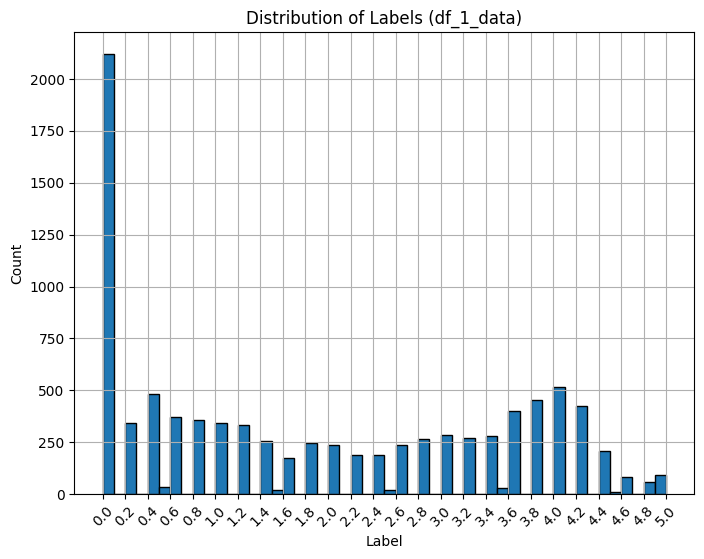

In [8]:
df = pd.read_csv('cos_sim.csv')

group_1 = df[df['cos_sim'] < 0.985]
print(f"Group 1 (0.981 이상): {len(group_1)} rows")

plt.figure(figsize=(8, 6))
plt.hist(df['label'], bins=[x / 10 for x in range(0, 51)], edgecolor='black')
plt.title('Distribution of Labels (df_1_data)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(True)

plt.xticks([x / 10 for x in range(0, 51, 2)], rotation=45)
plt.show()